In [244]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import geoviews

#============================================ Matan's paths =======================================================
# df_attack = pd.read_csv(r"C:\Users\Owner\Desktop\לימודים\תואר שני שנה ב\סמסטר ב\מדעי הנתונים\פרוייקט\pirates\Maritime-Pirate-Attacks-main\data\csv\pirate_attacks.csv")
# country_indc = pd.read_csv(r"C:\Users\Owner\Desktop\לימודים\תואר שני שנה ב\סמסטר ב\מדעי הנתונים\פרוייקט\pirates\Maritime-Pirate-Attacks-main\data\csv\country_indicators.csv")
# country_code = pd.read_csv(r"C:\Users\Owner\Desktop\לימודים\תואר שני שנה ב\סמסטר ב\מדעי הנתונים\פרוייקט\pirates\Maritime-Pirate-Attacks-main\data\csv\country_codes.csv")
#==================================================================================================================
#============================================ Saar's paths ========================================================
# df_attack = pd.read_csv(r"Origin_files\pirate_attacks.csv")
# country_indc = pd.read_csv(r"Origin_files\country_indicators.csv")
# country_code = pd.read_csv(r"Origin_files\country_codes.csv")
# #===================================================================================================================
# # ================================== Indexing the data for merge ICTZ work =========================================
# df_attack['attack_index'] = range(1, len(df_attack) + 1)
# df_attack = df_attack[['attack_index'] + [col for col in df_attack.columns if col != 'attack_index']]
#===================================================================================================================

## A: Merging Df's

In [246]:
country_full = country_indc.merge(country_code,how='left',on='country')
country_full.columns
reorder = ['country','country_name','region', 'year', 'corruption_index', 'homicide_rate', 'GDP',
       'total_fisheries_per_ton', 'total_military', 'population',
       'unemployment_rate', 'totalgr', 'industryofgdp'
       ]
country_full=country_full[reorder]

df_attack['datetime'] = pd.to_datetime(df_attack['date'])
df_attack['year'] = df_attack['datetime'].dt.year

df_attack=df_attack.rename(columns={'nearest_country':'country'})
data_merged = df_attack.merge(country_full,how='left',on=['country','year'])

data_merged = data_merged.rename(columns={'country':'nearest_c',
                            'country_name':'nearest_c_name',
                            'region':'nearest_c_region',
                            'corruption_index':'nearest_c_corruption_index',
                            'homicide_rate':'nearest_c_homicide_rate',
                            'GDP':'nearest_c_GDP',
                            'total_fisheries_per_ton':'nearest_c_total_fisheries_per_ton',
                            'total_military':'nearest_c_total_military',
                            'population':'nearest_c_population',
                            'unemployment_rate':'nearest_c_unemployment_rate',
                            'totalgr':'nearest_c_totalgr',
                            'industryofgdp':'nearest_c_industryofgdp'})

data_merged=data_merged.rename(columns={'eez_country':'country'})
data_merged1 = data_merged.merge(country_full,how='left',on=['country','year'])

data_merged1=data_merged1.rename(columns={'country':'eez_c',
                                        'country_name':'eez_c_name',
                                        'region':'eez_c_region',
                                        'corruption_index':'eez_c_corruption_index',
                                        'homicide_rate':'eez_c_homicide_rate',
                                        'GDP':'eez_c_GDP',
                                        'total_fisheries_per_ton':'eez_c_total_fisheries_per_ton',
                                        'total_military':'eez_c_total_military',
                                        'population':'eez_c_population',
                                        'unemployment_rate':'eez_c_unemployment_rate',
                                        'totalgr':'eez_c_totalgr',
                                        'industryofgdp':'eez_c_industryofgdp'})

df=data_merged1.copy()

### A1: Fixing Missing Values in Country tickers | names

In [248]:
#=====================Nearest================================
# Tikker with at least one obs with missing c_name
at_least_one_tnan_list = df[df['nearest_c'].isna()|df['nearest_c_name'].isna()]['nearest_c'].unique().tolist()
# country names with at least one obs with missing tikker
at_least_one_nnan_list = df[df['nearest_c'].isna()|df['nearest_c_name'].isna()]['nearest_c_name'].unique().tolist()
# print(at_least_one_nnan_list)
d = {}
for tik in at_least_one_tnan_list:
    list_filtered = df[df['nearest_c'] == tik]['nearest_c_name'].unique()
    # Use the first non-nan value if available, otherwise use "nan"
    valid_name = next((name for name in list_filtered if type(name) == str and name), np.nan)
    d[tik] = valid_name

# Adding missing names
code_to_name_mapping = {
    'CCK': 'Cocos (Keeling) Islands',
    'GLP': 'Guadeloupe',
    'GUF': 'French Guiana',
    'MTQ': 'Martinique',
    'MYT': 'Mayotte',
    'TWN': 'Taiwan'
}
for tik in code_to_name_mapping:
    if tik in d and (d[tik] is np.nan or d[tik] == 'nan'):  # Check if the value is nan
        d[tik] = code_to_name_mapping[tik]
       
d.pop(np.nan)

for key,value in d.items():
    df.loc[df['nearest_c']==key,'nearest_c_name']=value

# Tikker with at least one obs with missing c_name
at_least_one_tnan_list = df[df['nearest_c'].isna()|df['nearest_c_name'].isna()]['nearest_c'].unique().tolist()
# country names with at least one obs with missing tikker
at_least_one_nnan_list = df[df['nearest_c'].isna()|df['nearest_c_name'].isna()]['nearest_c_name'].unique().tolist()

#======================================================================================================================================================

#=====================Exclusive Economic Zone================================

# Tikker with at least one obs with missing c_name
at_least_one_tnan_list1 = df[df['eez_c'].isna()|df['eez_c_name'].isna()]['eez_c'].unique().tolist()
# country names with at least one obs with missing tikker
at_least_one_nnan_list1 = df[df['eez_c'].isna()|df['eez_c_name'].isna()]['eez_c_name'].unique().tolist()

d1 = {}
for tik in at_least_one_tnan_list1:
    list_filtered = df[df['nearest_c'] == tik]['nearest_c_name'].unique()
    # Use the first non-nan value if available, otherwise use "nan"
    valid_name = next((name for name in list_filtered if type(name) == str and name), np.nan)
    d1[tik] = valid_name

d1.pop(np.nan)

for key,value in d1.items():
    df.loc[df['eez_c']==key,'eez_c_name']=value

# Tikker with at least one obs with missing c_name
at_least_one_tnan_list1 = df[df['eez_c'].isna()|df['eez_c_name'].isna()]['eez_c'].unique().tolist()
# country names with at least one obs with missing tikker
at_least_one_nnan_list1 = df[df['eez_c'].isna()|df['eez_c_name'].isna()]['eez_c_name'].unique().tolist()

## A2: IMPORT ICTZ DATA (START FROM HERE)
- Our second code for ICTZ creation takes `df` and add crucial seasonal variables
- To skip this part we provide from now new data version: `mydata` contains those fields

In [250]:
# df.to_csv('my_data_temporary.csv', index=False)
mydata = pd.read_csv(r"mydata_itcz_seasons.csv")
mydata.columns

Index(['attack_index', 'date', 'time', 'longitude', 'latitude', 'attack_type',
       'location_description', 'nearest_c', 'eez_c', 'shore_distance',
       'shore_longitude', 'shore_latitude', 'attack_description',
       'vessel_name', 'vessel_type', 'vessel_status', 'data_source',
       'datetime', 'year', 'nearest_c_name', 'nearest_c_region',
       'nearest_c_corruption_index', 'nearest_c_homicide_rate',
       'nearest_c_GDP', 'nearest_c_total_fisheries_per_ton',
       'nearest_c_total_military', 'nearest_c_population',
       'nearest_c_unemployment_rate', 'nearest_c_totalgr',
       'nearest_c_industryofgdp', 'eez_c_name', 'eez_c_region',
       'eez_c_corruption_index', 'eez_c_homicide_rate', 'eez_c_GDP',
       'eez_c_total_fisheries_per_ton', 'eez_c_total_military',
       'eez_c_population', 'eez_c_unemployment_rate', 'eez_c_totalgr',
       'eez_c_industryofgdp', 'closest_Longitude', 'July_Upper_Latitude',
       'July_Lower_Latitude', 'January_Upper_Latitude',
       'J

## B: Variables de-coding

#### B1: Attack Outcome (generated from `attack_type`)

In [253]:
#replaicing boarding with boarded (similar meaning). 
mydata.loc[mydata['attack_type']=='Boarding','attack_type']='Boarded'

#create new categorical attack variable
attack_categories = {
    'Successful': ['Hijacked', 'Boarded', 'Detained','Explosion'],
    'Unsuccessful': ['Attempted', 'Fired Upon']}

attack_to_category = {attack: category for category, attacks in attack_categories.items() for attack in attacks}
mydata['attack_outcome'] = mydata['attack_type'].map(attack_to_category).fillna('Unknown')
#===================================================================
#===== numeric version for logistic model [Unsuccessful==1] ========
mydata['outcome']=np.where(mydata['attack_outcome']=='Successful',0,1)
mydata['outcome'].value_counts()

outcome
0    5303
1    2208
Name: count, dtype: int64

#### B1.1: Filtering out the `Unkown` attack results 

In [255]:
mydata=mydata[mydata['attack_outcome']!='Unknown'].copy()
#From 7511 attacks to 7375 attacks (136 omitted)

#### B2: Vessel Status

In [257]:
def categorize_vessel_status(status):
    status = status.strip().capitalize() if pd.notnull(status) else status
    if status in ['Steaming', 'Underway', 'Drifting', 'Towed', 'Fishing', 'Bunkering operations']:
        return 'In motion'
    elif status in ['Anchored', 'Berthed', 'Moored', 'Stationary', 'Grounded']:
        return 'Stationary'
    elif pd.isnull(status):
        return 'Unknown'
    else:
        return 'Unknown'

mydata['vstatus_category'] = mydata['vessel_status'].apply(categorize_vessel_status)

#### B3: Vessel categories (limited - only 1154 obs)

In [259]:
# vessel type categories
vessel_categories = {
    'Tanker (liquid goods)': ['Chemical Tanker', 'LPG Tanker', 'Product Tanker', 'Crude Tanker', 
                'Bunkering Tanker', 'LNG Tanker', 'Crude Oil Tanker', 
                'Asphalt/Bitumen Tanker', 'Tanker', 'Oil Tanker', 'PRODUCT TANKER'],
    'Cargo Ship (solid goods)': ['General Cargo', 'Bulk Carrier', 'Vehicle Carrier', 'Container', 
                    'Refrigerated Cargo', 'Wood Chips Carrier', 'Ore Carrier', 
                    'Heavy Load Carrier', 'Cement Carrier', 'RO-RO CARGO SHIP', 
                    'Ro-Ro', 'CONTAINER', 'BULK CARRIER'],
    'Offshore Support Vessel': ['Offshore Supply Ship', 'Offshore Support Vessel', 
                                 'Offshore Supply', 'Supply Vessel', 'Support', 
                                 'OFFSHORE SUPPLY SHIP', 'Offshore Supply ship'],
    'Specialized Vessel': ['Pipe Lay Barge', 'Floating Production Storage and Offloading', 
                            'Floating Storage and Offloading', 'Cable Ship', 'Pipe Layer', 
                            'Research Vessel', 'Dredger', 'Hopper Dredger', 'FPSO', 'Landing Craft', 'Maintenance Pontoon'],
    'Tug or Barge': ['Tug and Barge', 'Tug', 'Tug / Barge', 'Offshore Tug', 
                        'Accommodation Barge'],
    'Fishing Vessel': ['Fishing Vessel'],
    'Passenger Vessel': ['Passenger Ship', 'Passenger Boat','Yacht', 'Pleasure Craft', 'Dhow']}
vessel_to_category = {vessel: category for category, vessels in vessel_categories.items() for vessel in vessels}
mydata['vessel_category'] = mydata['vessel_type'].map(vessel_to_category).fillna('Unknown')

mydata['vessel_category'].value_counts()

vessel_category
Unknown                     6221
Cargo Ship (solid goods)     544
Tanker (liquid goods)        456
Tug or Barge                  62
Offshore Support Vessel       36
Fishing Vessel                26
Specialized Vessel            23
Passenger Vessel               7
Name: count, dtype: int64

#### B4: Decades & month

In [261]:
mydata['datetime'] = pd.to_datetime(mydata['date'], dayfirst=True)
mydata['month'] = mydata['datetime'].dt.month

mydata['decade']=np.nan
mydata.loc[mydata['year']<=1999,'decade']="1990's"
mydata.loc[(mydata['year']>1999)&(mydata['year']<2010),'decade']="2000's"
mydata.loc[mydata['year']>=2010,'decade']="2010's"
mydata['decade'].value_counts()

C:\Users\saarp\AppData\Local\Temp\ipykernel_20520\35992667.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1990's' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  mydata.loc[mydata['year']<=1999,'decade']="1990's"


decade
2000's    3392
2010's    2842
1990's    1141
Name: count, dtype: int64

#### B5: Exclusive Economic Zone Country region

In [263]:
# Combine North America and Latin America & Caribbean
mydata['eez_c_region'] = mydata['eez_c_region'].replace({'North America': 'America & Caribbean', 'Latin America & Caribbean': 'America & Caribbean'})

# Combine Middle East & North Africa and Europe & Central Asia
mydata['eez_c_region'] = mydata['eez_c_region'].replace({'Middle East & North Africa': 'Middle East & Europe', 'Europe & Central Asia': 'Middle East & Europe'})

In [264]:
eez_c_region_counts = mydata['eez_c_region'].value_counts()
eez_c_region_percentages = mydata['eez_c_region'].value_counts(normalize=True) * 100

eez_c_region_table = pd.DataFrame({'Count': eez_c_region_counts, 'Percentage': eez_c_region_percentages})
eez_c_region_table.index.name = 'EEZ C Region'

eez_c_region_table

,Count,Percentage
EEZ C Region,,
East Asia & Pacific,3056,44.431521
Sub-Saharan Africa,1535,22.317534
South Asia,855,12.430939
America & Caribbean,730,10.613550
Middle East & Europe,702,10.206455


#### B6: Distance from equator:

In [266]:
mydata['equator_distance'] = mydata['latitude'].abs() * 111.32
mydata['equator_distance'].describe()

count    7375.000000
mean     1033.747313
std       881.323424
min         0.000000
25%       365.811744
50%       698.533000
75%      1494.843922
max      5977.086203
Name: equator_distance, dtype: float64

#### B7: Custom regions

In [268]:
def assign_custom_region(row):
    lat, lon = row['latitude'], row['longitude']
    
    # North Africa, Europe, and Central Asia
    if (lat >= 40 and -50 <= lon <= 70) or (lat >= 30 and -20 <= lon <= 40):
        return 'North Africa, Europe, and Central Asia'
    
    # Americas (North America + Latin America and Caribbean)
    elif (-60 <= lat <= 90) and (-180 <= lon <= -30):
        return 'Americas'
    
    # West Africa
    elif (0 <= lat < 30) and (-20 <= lon <= 15):
        return 'West Africa'
    
    # East Africa and Middle East
    elif (-20 <= lat < 40) and (15 < lon <= 60):
        return 'East Africa and Middle East'
    
    # South Asia
    elif (0 <= lat <= 35) and (60 < lon <= 100):
        return 'South Asia'
    
    # East Asia and Pacific
    elif (-10 <= lat <= 60) and (100 < lon <= 180):
        return 'East Asia and Pacific'
    
    # If it doesn't fit into any of these regions, assign it to the nearest one
    else:
        regions = [
            ('North Africa, Europe, and Central Asia', (45, 20)),
            ('Americas', (0, -90)),
            ('West Africa', (15, 0)),
            ('East Africa and Middle East', (10, 40)),
            ('South Asia', (20, 80)),
            ('East Asia and Pacific', (20, 120))
        ]
        distances = [((lat - r[1][0])*2 + (lon - r[1][1])*2) for r in regions]
        return regions[distances.index(min(distances))][0]

# Apply the function to your dataframe
mydata['custom_region'] = mydata.apply(assign_custom_region, axis=1)

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(
    mydata, geometry=gpd.points_from_xy(mydata.longitude, mydata.latitude))

# Verify that 'custom_region' is in the GeoDataFrame
print(gdf['custom_region'].value_counts())

custom_region
East Asia and Pacific                     2938
South Asia                                1330
East Africa and Middle East               1215
West Africa                               1066
Americas                                   762
North Africa, Europe, and Central Asia      64
Name: count, dtype: int64


## C: Mapping:

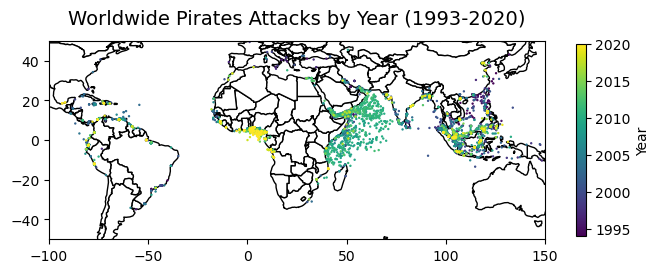

In [270]:
map_path_high = r"C:\Users\saarp\Desktop\71253\Project\Admin 0 – Countries\ne_10m_admin_0_countries.shp"
map_path_low = r"C:\Users\saarp\Desktop\71253\Project\Admin 0 – Countries\ne_110m_admin_0_countries.shp"

# map_path_high = r"C:\Users\Owner\Desktop\לימודים\תואר שני שנה ב\סמסטר ב\מדעי הנתונים\פרוייקט\pirates\map\ne_10m_admin_0_countries.shp"
# map_path_low = r"C:\Users\Owner\Desktop\לימודים\תואר שני שנה ב\סמסטר ב\מדעי הנתונים\פרוייקט\pirates\map\ne_110m_admin_0_countries.shp"


gdf = gpd.GeoDataFrame(
    mydata, geometry=gpd.points_from_xy(mydata.longitude, mydata.latitude))
world = gpd.read_file(map_path_low)
fig, ax = plt.subplots(figsize=(8, 5))
world.plot(ax=ax, color='white', edgecolor='black')
# Plot 'gdf' with a color map
cbar_plot = gdf.plot(ax=ax, column='year', cmap='viridis', legend=True, markersize=0.5, legend_kwds={'label': "Year", 'orientation': "vertical",'shrink': 0.5})

ax.set_xlim([-100, 150])  # Set x-axis 
ax.set_ylim([-50, 50])    # Set y-axis 

# ax.axhline(y=-5, color='black', linestyle='--', linewidth=1.2)
# ax.axhline(y=5, color='black', linestyle='--', linewidth=1.2)

# ax.axhline(y=-10, color='gray', linestyle='--', linewidth=0.75)
# ax.axhline(y=10, color='gray', linestyle='--', linewidth=0.75)

ax.set_title("Worldwide Pirates Attacks by Year (1993-2020)", fontdict={'fontsize': 14}, pad=12)

# Show plot
plt.show()

#### C1: Map as a function
- `mup_func(df,var,"title",distance)`

In [272]:
def map_func(df,var,title="",dist=20):
    min_lng = df['longitude'].min() -dist
    max_lng = df['longitude'].max() +dist
    min_lat = df['latitude'].min() -dist
    max_lat = df['latitude'].max() +dist
    gdf = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
    world = gpd.read_file(map_path_low)
    fig, ax = plt.subplots(figsize=(12, 8))
    world.plot(ax=ax, color='white', edgecolor='black')
    # Plot 'gdf' with a color map
    cbar_plot = gdf.plot(ax=ax, column=var, cmap='viridis', legend=True, markersize=10, )#legend_kwds={'label': "Year", 'orientation': "vertical"})

    ax.set_xlim([min_lng, max_lng])  # Set x-axis 
    ax.set_ylim([min_lat, max_lat])    # Set y-axis 
    ax.axhline(y=-5, color='black', linestyle='--', linewidth=1)
    ax.axhline(y=5, color='black', linestyle='--', linewidth=1)
    
    ax.axhline(y=-7.5, color='gray', linestyle='--', linewidth=0.5)
    ax.axhline(y=7.5, color='gray', linestyle='--', linewidth=0.5)
    ax.set_title(f"{title} - {len(df)} attacks", fontdict={'fontsize': 15}, pad=20)
    # Show plot
    plt.show()

# map_func(mydata,'nearest_c_region')

## D: Mydata Analyze

#### D1: Description of Categorial variables

In [276]:
crosstab_df = pd.crosstab(mydata['Geogrphical_region'], mydata['Geogrphical_season'])
crosstab_df['Total'] = crosstab_df.sum(axis=1)
crosstab_df.loc['Total'] = crosstab_df.sum()
crosstab_df

Geogrphical_season,Autumn,Dry Season,Spring,Summer,Wet Season,Winter,Total
Geogrphical_region,,,,,,,
Equatorial/Tropical Region,0,1910,0,0,1182,0,3092
Northern Hemisphere,259,0,312,45,0,709,1325
Southern Hemisphere,867,0,722,110,0,1259,2958
Total,1126,1910,1034,155,1182,1968,7375


Text(0.5, 1.0, 'Counts of Attacks by Geogrphical region and Outcome')

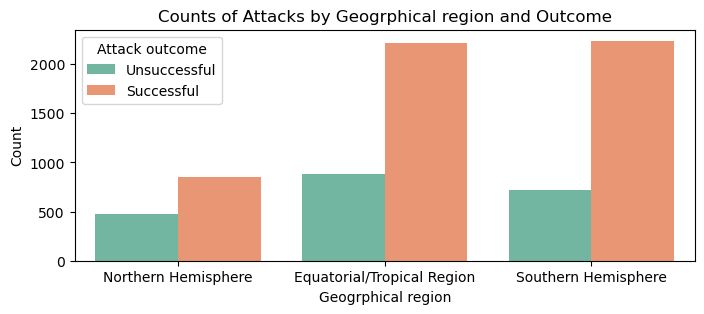

In [277]:
mydata['Geogrphical_region'].value_counts()

plt.figure(figsize=(8, 3))
sns.countplot(data=mydata, x='Geogrphical_region', hue='attack_outcome', palette="Set2")
plt.xlabel('Geogrphical region')
plt.ylabel('Count')
plt.legend(title='Attack outcome')
plt.xticks(rotation=0)  
plt.title('Counts of Attacks by Geogrphical region and Outcome')

In [278]:
mydata['custom_region2'] = mydata['custom_region']
mydata.loc[(mydata['custom_region']!= 'East Asia and Pacific') &
            (mydata['custom_region']!='East Africa and Middle East'), 'custom_region2']='Rest of the World'


mydata['custom_region2'].value_counts()

custom_region2
Rest of the World              3222
East Asia and Pacific          2938
East Africa and Middle East    1215
Name: count, dtype: int64

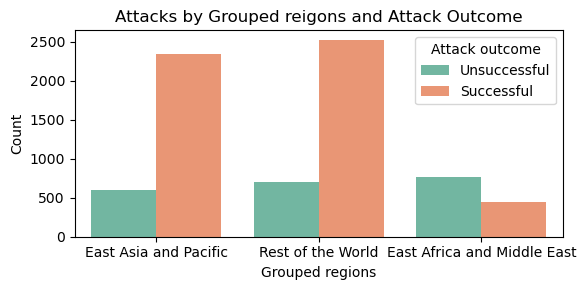

In [298]:
plt.figure(figsize=(6, 3))  
sns.countplot(data=mydata, x='custom_region2', hue='attack_outcome', palette="Set2")
plt.xlabel('Grouped regions')
plt.ylabel('Count')
plt.legend(title='Attack outcome', loc='upper right')
plt.title('Attacks by Grouped reigons and Attack Outcome')
plt.xticks(rotation=0)  
plt.tight_layout()  
plt.show()

<Figure size 400x200 with 0 Axes>

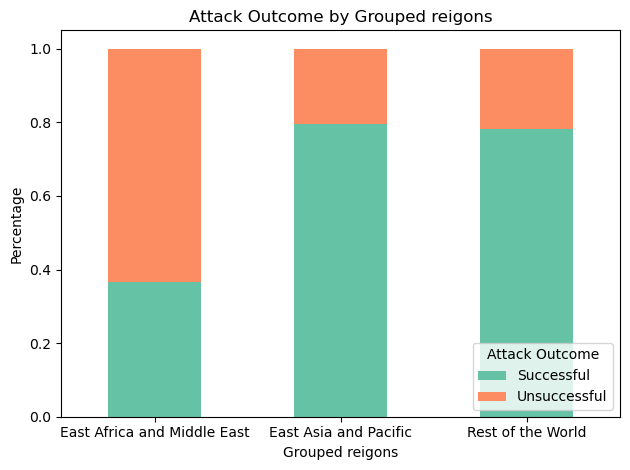

In [302]:
#optional: ill explain

colors = ['#66c2a5', '#fc8d62']

plt.figure(figsize=(4, 2))
pd.crosstab(mydata['custom_region2'], mydata['attack_outcome'], normalize='index').plot(
    kind='bar', stacked=True, color=colors
)
plt.xlabel('Grouped reigons')
plt.ylabel('Percentage')
plt.title('Attack Outcome by Grouped reigons')
plt.legend(title='Attack Outcome', loc='lower right')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()




Frequency table for vstatus_category:
vstatus_category
Stationary    0.531525
In motion     0.360949
Unknown       0.107525
Name: proportion, dtype: float64


Text(0.5, 1.0, 'Counts of Vessel Status by Attack Outcome')

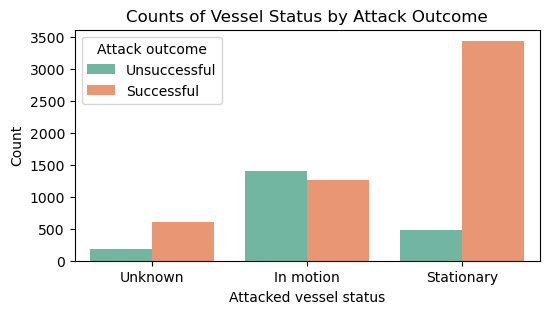

In [151]:
print("\nFrequency table for vstatus_category:")
print(mydata['vstatus_category'].value_counts(normalize=True))


plt.figure(figsize=(6, 3))
sns.countplot(data=mydata, x='vstatus_category', hue='attack_outcome', palette="Set2")
plt.xlabel('Vessel Status')
plt.ylabel('Count')
plt.legend(title='Attack outcome')
plt.xlabel("Attacked vessel status")
plt.title('Counts of Vessel Status by Attack Outcome')

Text(0.5, 1.0, 'Mean Distance from Shore by Vessel Status and Attack Outcome')

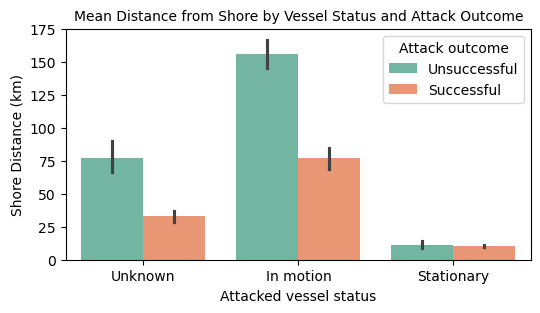

In [152]:
plt.figure(figsize=(6, 3))
sns.barplot(data=mydata, x="vstatus_category", y="shore_distance", hue="attack_outcome",errorbar='ci', palette="Set2")
plt.legend(title='Attack outcome')
plt.xlabel("Attacked vessel status")
plt.ylabel("Shore Distance (km)")
plt.title('Mean Distance from Shore by Vessel Status and Attack Outcome', fontsize=10)


Frequency table for decade:
decade
2000's    0.459932
2010's    0.385356
1990's    0.154712
Name: proportion, dtype: float64


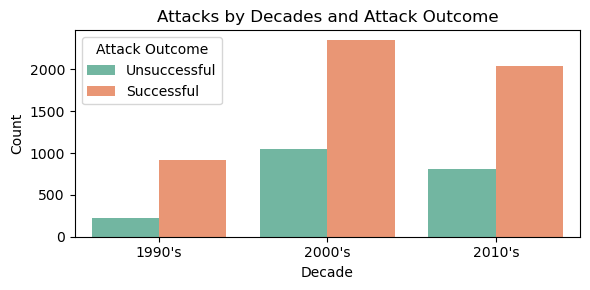

In [153]:
print("\nFrequency table for decade:")
print(mydata['decade'].value_counts(normalize=True))


plt.figure(figsize=(6, 3))
sns.countplot(data=mydata, x='decade', hue='attack_outcome', palette="Set2")
plt.title('Attacks by Decades and Attack Outcome')
plt.xlabel('Decade')
plt.ylabel('Count')
plt.legend(title='Attack Outcome', loc='upper left')
plt.tight_layout()
plt.show()


Frequency table for Geogrphical_season:
Geogrphical_season
Winter        0.266847
Dry Season    0.258983
Wet Season    0.160271
Autumn        0.152678
Spring        0.140203
Summer        0.021017
Name: proportion, dtype: float64


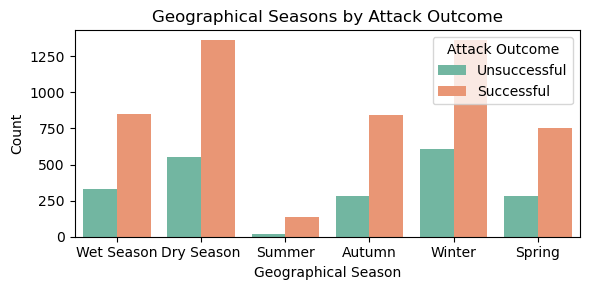

In [154]:
season_order = ['Wet Season', 'Dry Season', 'Summer', 'Autumn', 'Winter', 'Spring']

mydata['Geogrphical_season'] = pd.Categorical(mydata['Geogrphical_season'], categories=season_order, ordered=True)

print("\nFrequency table for Geogrphical_season:")
print(mydata['Geogrphical_season'].value_counts(normalize=True))

plt.figure(figsize=(6, 3))
sns.countplot(data=mydata, x='Geogrphical_season', hue='attack_outcome', order=season_order, palette="Set2")
plt.title('Geographical Seasons by Attack Outcome')
plt.xlabel('Geographical Season')
plt.ylabel('Count')
plt.legend(title='Attack Outcome', loc='upper right')
plt.tight_layout()
plt.show()


Frequency table for eez_region:
eez_c_region
East Asia & Pacific     0.444315
Sub-Saharan Africa      0.223175
South Asia              0.124309
America & Caribbean     0.106136
Middle East & Europe    0.102065
Name: proportion, dtype: float64


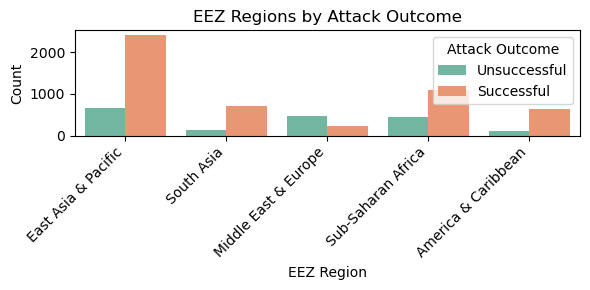

In [155]:
print("\nFrequency table for eez_region:")
print(mydata['eez_c_region'].value_counts(normalize=True))


plt.figure(figsize=(6, 3))
sns.countplot(data=mydata, x='eez_c_region', hue='attack_outcome', palette="Set2")
plt.title('EEZ Regions by Attack Outcome')
plt.xlabel('EEZ Region')
plt.ylabel('Count')
plt.legend(title='Attack Outcome', loc='upper right')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [156]:
pd.DataFrame(mydata['eez_c_name'].value_counts().head(15))

,count
eez_c_name,
Indonesia,1962
Nigeria,550
Malaysia,472
Bangladesh,468
"Yemen, Rep.",466
India,338
Philippines,218
Vietnam,191
Somalia,161


In [157]:
categorical_list = ['attack_outcome', 'vstatus_category', 'decade', 'Geogrphical_season', 'eez_c_region' ,'vessel_category']

variable_info = []

for col in categorical_list:
    if col == 'vessel_category':
        variable_info.append({
            'Variable': col,
            'Number of Observations': mydata[mydata[col] != 'Unknown'][col].count(),
            'Number of Categories': mydata[mydata[col] != 'Unknown'][col].nunique(),
            'Most Common Category': mydata[mydata[col] != 'Unknown'][col].mode()[0],
            'Percentage of Most Common': (mydata[mydata[col] != 'Unknown'][col].value_counts().iloc[0] / mydata[mydata[col] != 'Unknown'][col].count()) * 100
        })
    else:
        variable_info.append({
            'Variable': col,
            'Number of Observations': mydata[col].count(),
            'Number of Categories': mydata[col].nunique(),
            'Most Common Category': mydata[col].mode()[0],
            'Percentage of Most Common': (mydata[col].value_counts().iloc[0] / mydata[col].count()) * 100
        })

info_df = pd.DataFrame(variable_info)
info_df['Percentage of Most Common'] = info_df['Percentage of Most Common'].round(2)

print(info_df.to_string(index=False))

          Variable  Number of Observations  Number of Categories     Most Common Category  Percentage of Most Common
    attack_outcome                    7375                     2               Successful                      71.91
  vstatus_category                    7375                     3               Stationary                      53.15
            decade                    7375                     3                   2000's                      45.99
Geogrphical_season                    7375                     6                   Winter                      26.68
      eez_c_region                    6878                     5      East Asia & Pacific                      44.43
   vessel_category                    1154                     7 Cargo Ship (solid goods)                      47.14


#### D2: Description of quantitative variables

In [159]:
varlist = ['shore_distance','equator_distance',
           'eez_c_population', 'eez_c_GDP','eez_c_total_fisheries_per_ton', 'eez_c_totalgr', 'eez_c_total_military',                   
           'eez_c_corruption_index','eez_c_homicide_rate','eez_c_unemployment_rate', 'eez_c_industryofgdp'
           ]
desmdata = mydata[['attack_outcome'] + varlist]

successful_data = desmdata[desmdata['attack_outcome'] == 'Successful']
unsuccessful_data = desmdata[desmdata['attack_outcome'] == 'Unsuccessful']

successful_stats = successful_data[varlist].agg(['count', 'mean', 'median', 'std', 'min', 'max']).T
unsuccessful_stats = unsuccessful_data[varlist].agg(['count', 'mean', 'median', 'std', 'min', 'max']).T

comparison_df = successful_stats.join(unsuccessful_stats, lsuffix='_Successful', rsuffix='_Unsuccessful')
comparison_df = comparison_df.round(2)

comparison_df

,count_Successful,mean_Successful,median_Successful,std_Successful,min_Successful,max_Successful,count_Unsuccessful,mean_Unsuccessful,median_Unsuccessful,std_Unsuccessful,min_Unsuccessful,max_Unsuccessful
shore_distance,5303.0,2.865000e+01,7.060000e+00,8.017000e+01,0.04,1.006510e+03,2072.0,1.149300e+02,36.27,1.877600e+02,0.08,1.024030e+03
equator_distance,5303.0,1.028330e+03,6.777900e+02,9.231200e+02,0.00,5.977090e+03,2072.0,1.047620e+03,888.70,7.640500e+02,0.00,5.975270e+03
eez_c_population,5062.0,1.978914e+08,1.369864e+08,2.895183e+08,76417.00,1.397715e+09,1816.0,1.390242e+08,29866559.00,2.508335e+08,17955.00,1.392730e+09
eez_c_GDP,4945.0,2.866490e+03,1.573880e+03,4.767920e+03,102.60,6.618878e+04,1731.0,2.735400e+03,1229.25,4.443280e+03,137.17,6.523328e+04
eez_c_total_fisheries_per_ton,4645.0,5.354969e+06,2.328545e+06,8.016169e+06,320.00,8.150000e+07,1702.0,3.101570e+06,636901.00,6.190093e+06,800.00,7.880000e+07
eez_c_totalgr,4143.0,1.800000e-01,1.600000e-01,8.000000e-02,0.01,6.700000e-01,1447.0,2.100000e-01,0.18,9.000000e-02,0.02,6.100000e-01
eez_c_total_military,4657.0,5.167571e+05,2.800000e+05,7.198978e+05,50.00,4.135000e+06,1666.0,3.755348e+05,149000.00,6.375413e+05,200.00,4.135000e+06
eez_c_corruption_index,4449.0,1.252000e+01,3.000000e+00,1.534000e+01,0.40,8.700000e+01,1583.0,8.770000e+00,2.65,1.233000e+01,0.40,8.500000e+01
eez_c_homicide_rate,3211.0,6.600000e+00,2.380000e+00,1.123000e+01,0.16,6.945000e+01,1192.0,6.020000e+00,3.99,9.460000e+00,0.30,6.945000e+01
eez_c_unemployment_rate,5046.0,5.620000e+00,4.510000e+00,3.060000e+00,0.58,3.184000e+01,1792.0,7.190000e+00,6.08,4.000000e+00,0.63,3.246000e+01


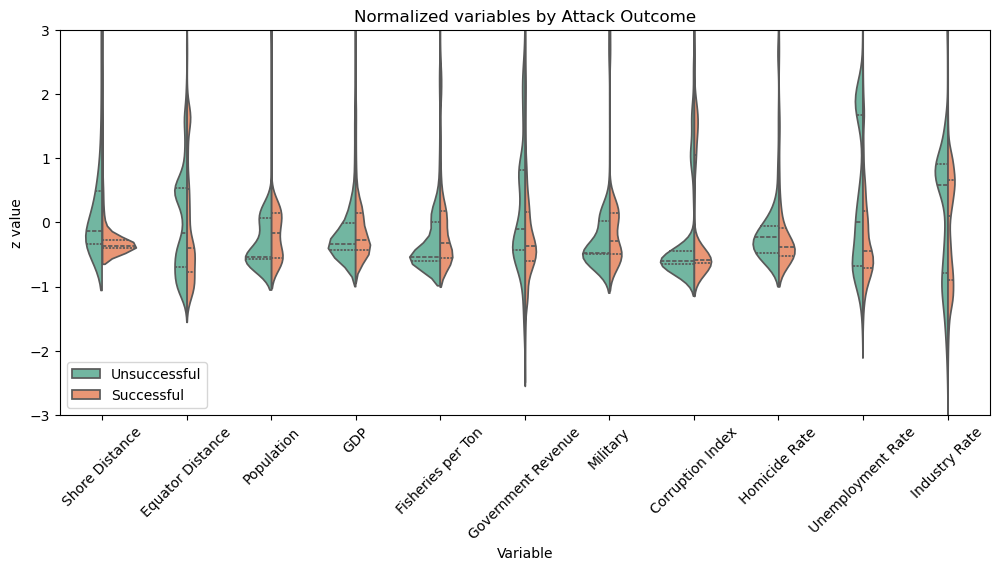

In [160]:
# Z-Score Normalization
z = mydata[varlist].apply(lambda x:(x-x.mean())/x.std(), axis=0)
z['attack_outcome'] = mydata['attack_outcome']

melted_z = z.melt(id_vars="attack_outcome", value_vars=varlist, var_name="Variable", value_name="Value")

custom_labels = ['Shore Distance', 'Equator Distance', 'Population', 'GDP', 'Fisheries per Ton', 
                 'Government Revenue', 'Military', 'Corruption Index', 'Homicide Rate', 
                 'Unemployment Rate', 'Industry Rate']

plt.figure(figsize=(12, 5))
sns.violinplot(x="Variable", y="Value", hue="attack_outcome", data=melted_z, split=True, inner="quart", palette="Set2")
plt.title('Normalized variables by Attack Outcome')
plt.xticks(ticks=range(len(varlist)), labels=custom_labels, rotation=45)
plt.ylim([-3,3])
plt.legend(loc='lower left')
plt.ylabel('z value')
plt.show()

#### D3: Permutations & correlation Heatmap 

In [162]:
def premutations(varlist):
    premdata = mydata[['attack_outcome'] + varlist]
   
    results_df = pd.DataFrame(columns=['Variable','Successful Attacks', 'Unsuccessful Attacks','Successful Attacks Mean',
                                       'Unsuccessful Attacks Mean', 'Means difference',
                                       'Perm p.value'])
    
    for var in varlist:
        premdata1 = premdata[premdata[var].notna()]
        s_count = len(premdata1[premdata1['attack_outcome'] == 'Successful'])
        u_count = len(premdata1[premdata1['attack_outcome'] == 'Unsuccessful'])

        s_med = premdata[premdata['attack_outcome'] == 'Successful'][var].mean()
        u_med = premdata[premdata['attack_outcome'] == 'Unsuccessful'][var].mean()
        abs_median_diff = (s_med - u_med)
        runs = 5000
        diffs = np.zeros(runs)
        for ii in range(runs):
            premdata.loc[:, 'outcome_shuffled'] = premdata['attack_outcome'].sample(frac=1, replace=False).values
            grouped = premdata.groupby('outcome_shuffled', observed=True)[var].mean()
            diffs[ii] = np.abs(grouped['Successful'] - grouped['Unsuccessful'])
            # diffs[ii] = np.abs() for two-sided p-value
    
        larger = np.where(diffs >= np.abs(abs_median_diff), 1, 0)
        p_val = np.sum(larger) / runs
        
        current_row = pd.DataFrame({
            'Variable': [var],
            'Successful Attacks':[s_count],
            'Unsuccessful Attacks':[u_count],
            'Successful Attacks Mean': [round(s_med, 2)],
            'Unsuccessful Attacks Mean': [round(u_med, 2)],
            'Means difference': [round(abs_median_diff, 2)],
            'Perm p.value': [round(p_val, 4)]
        })
        
        results_df = pd.concat([results_df, current_row], ignore_index=True)
    return results_df


In [163]:
vlist = ['shore_distance','equator_distance',
           'eez_c_GDP',
           'eez_c_population',
           'eez_c_corruption_index',
           'eez_c_homicide_rate',
           'eez_c_total_military',
           'eez_c_unemployment_rate',
           'eez_c_totalgr',
           'eez_c_industryofgdp',
           'eez_c_total_fisheries_per_ton']

# premutations(vlist)

##### Correlations Heatmap

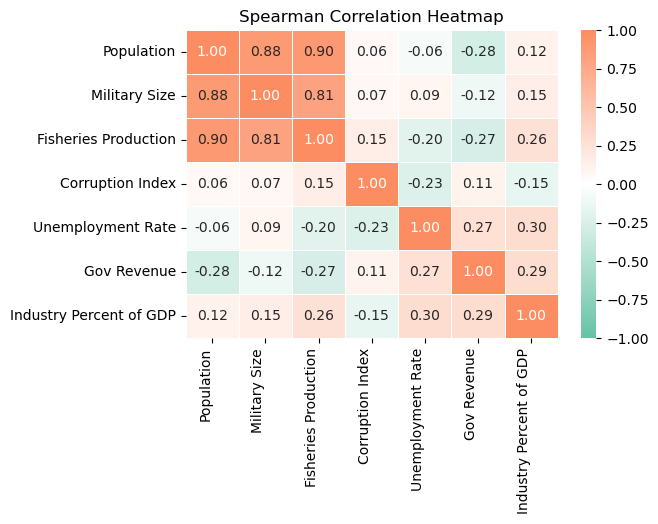

In [240]:
from matplotlib.colors import LinearSegmentedColormap

vlist1 = [ 'eez_c_population',
           'eez_c_total_military',
           'eez_c_total_fisheries_per_ton',
           'eez_c_corruption_index',
           'eez_c_unemployment_rate',
           'eez_c_totalgr',
           'eez_c_industryofgdp',
           ]

palette = sns.color_palette("Set2")
turquoise = palette[0]
salmon = palette[1]
# Create a custom colormap
colors = [turquoise, "white", salmon]
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

corr_df = mydata[vlist1]

new_labels = [
    'Population',
    'Military Size',
    'Fisheries Production',
    'Corruption Index',
    'Unemployment Rate',
    'Gov Revenue',
    'Industry Percent of GDP',
]

corr_matrix = corr_df.corr(method='spearman')
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap=cmap, fmt=".2f", linewidths=.5,vmin=-1,vmax=1)
# Set the labels
plt.xticks(ticks=np.arange(len(new_labels)) + 0.5, labels=new_labels, rotation=90, ha='right')
plt.yticks(ticks=np.arange(len(new_labels)) + 0.5, labels=new_labels, rotation=0)

plt.title('Spearman Correlation Heatmap')
plt.show()

#### D4: Logitic Model

In [167]:
from sklearn.linear_model import LogisticRegression
from scipy.special import expit
import statsmodels.api as sm

In [168]:
mydata['log_sdistance'] = np.log(mydata['shore_distance'])
mydata['log_eez_population'] = np.log(mydata['eez_c_population'])
mydata['log_eez_corruption_index'] = np.log(mydata['eez_c_corruption_index'])
mydata['log_eez_unemployment_rate'] = np.log(mydata['eez_c_unemployment_rate'])
mydata['log_eez_totalgr'] = np.log(mydata['eez_c_totalgr'])
mydata['log_eez_industryofgdp'] = np.log(mydata['eez_c_industryofgdp'])

In [169]:
# Define categorical variables and their encodings
categorical_vars1 = ['Geogrphical_region', 'decade', 'vstatus_category','custom_region2']
seasonal_encoding = {'Southern Hemisphere': 0,'Northern Hemisphere': 1, 'Equatorial/Tropical Region': 2}
region_encoding = {'East Africa and Middle East': 0,'East Asia and Pacific': 1, 'South Asia': 2,
                   'West Africa':3,'Americas':4,'North Africa, Europe, and Central Asia':5}
region_encoding = {'Rest of the World': 0,'East Asia and Pacific': 1, 'East Africa and Middle East': 2,}
                   # 'West Africa':3,'Americas':4,'North Africa, Europe, and Central Asia':5}
decade_encoding = {"1990's": 0, "2000's": 1, "2010's": 2}
vessel_status_encoding = {'In motion': 0, 'Stationary': 1, 'Unknown': 2}

encodings = {
    'Geogrphical_region': seasonal_encoding,
    'decade': decade_encoding,
    'vstatus_category':vessel_status_encoding,
    'custom_region2':region_encoding
}

#Encoding
for var in categorical_vars1:
    mydata[var] = mydata[var].map(encodings[var])

mydata['Northern Hemisphere'] = np.where(mydata['Geogrphical_region'] == 1, 1, 0)
mydata['Equatorial/Tropical'] = np.where(mydata['Geogrphical_region'] == 2, 1, 0)

mydata['East Asia and Pacific'] = np.where(mydata['custom_region2'] == 1, 1, 0)
mydata['East Africa and Middle East'] = np.where(mydata['custom_region2'] == 2, 1, 0)

mydata["2000's"] = np.where(mydata['decade'] == 1, 1, 0)
mydata["2010's"] = np.where(mydata['decade'] == 2, 1, 0)

mydata['Vessel is Stationary'] = np.where(mydata['vstatus_category'] == 1, 1, 0)
mydata['Vessel status is Unknown'] = np.where(mydata['vstatus_category'] == 2, 1, 0)

# categorical_vars2 = ['decade', 'vstatus_category']
# #Dummies    
# for var in categorical_vars2:
#     dummies = pd.get_dummies(mydata[var], prefix=var, drop_first=True)
#     mydata = pd.concat([mydata, dummies], axis=1)

mydata=mydata.rename(columns={
                                'log_sdistance': 'Log Shore Distance',
                                'log_eez_population': 'Log EEZ Population',
                                'log_eez_corruption_index': 'Log EEZ Corruption Index',
                                'log_eez_unemployment_rate': 'Log EEZ Unemployment Rate',
                                'log_eez_industryofgdp': 'Log EEZ Industry of GDP'})
                              

In [206]:
mydata.columns

Index(['attack_index', 'date', 'time', 'longitude', 'latitude', 'attack_type',
       'location_description', 'nearest_c', 'eez_c', 'shore_distance',
       'shore_longitude', 'shore_latitude', 'attack_description',
       'vessel_name', 'vessel_type', 'vessel_status', 'data_source',
       'datetime', 'year', 'nearest_c_name', 'nearest_c_region',
       'nearest_c_corruption_index', 'nearest_c_homicide_rate',
       'nearest_c_GDP', 'nearest_c_total_fisheries_per_ton',
       'nearest_c_total_military', 'nearest_c_population',
       'nearest_c_unemployment_rate', 'nearest_c_totalgr',
       'nearest_c_industryofgdp', 'eez_c_name', 'eez_c_region',
       'eez_c_corruption_index', 'eez_c_homicide_rate', 'eez_c_GDP',
       'eez_c_total_fisheries_per_ton', 'eez_c_total_military',
       'eez_c_population', 'eez_c_unemployment_rate', 'eez_c_totalgr',
       'eez_c_industryofgdp', 'closest_Longitude', 'July_Upper_Latitude',
       'July_Lower_Latitude', 'January_Upper_Latitude',
       'J

In [210]:
# Prepare X and y for the model
continuous_vars = ['Log Shore Distance', 'Log EEZ Population', 'Log EEZ Corruption Index',
                   'Log EEZ Unemployment Rate','Log EEZ Industry of GDP',]

dummy_vars = [ 'Equatorial/Tropical', 'East Asia and Pacific',
               'East Africa and Middle East', "2000's",
               "2010's", 'Vessel is Stationary', 'Vessel status is Unknown',]

X = mydata[continuous_vars + dummy_vars]

# Handle non-finite values before converting types
X = X.replace([np.inf, -np.inf], np.nan).dropna()

# Convert boolean columns to int
X = X.astype(int)

# Add constant term
X = sm.add_constant(X)

y = mydata['outcome']

# Clean the data
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y[X.index]

# Fit the model
model = sm.Logit(y, X)
result = model.fit()


# Rename the coefficients in the summary output
# coef_rename = {
    # 'Geogrphical_region_1': 'Northern Hemisphere',
    # 'Geogrphical_region_2': 'Equatorial/Tropical',
    # 'custom_region_1':'East Asia and Pacific',
    # 'custom_region_2':'South Asia',
    # 'custom_region_3':'West Africa',
    # 'custom_region_4':'Americas',
    # 'custom_region_5':'North Africa, Europe, and Central Asia',
    # 'decade_1': "2000's",
    # 'decade_2': "2010's",
    # 'vstatus_category_1': 'Vessel is stationary',
    # 'vstatus_category_2': 'Vessel status is Unknown',
#     'log_sdistance': 'Log Shore Distance',
#     'log_eez_population': 'Log EEZ Population',
#     'log_eez_corruption_index': 'Log EEZ Corruption Index',
#     'log_eez_unemployment_rate': 'Log EEZ Unemployment Rate',
#     'log_eez_industryofgdp': 'Log EEZ Industry of GDP'
# }

summary = result.summary2()
# summary_df = summary.tables[1].copy()
# # summary_df.rename(index=coef_rename, inplace=True)
# summary.tables[1] = summary_df
print(summary)

Optimization terminated successfully.
         Current function value: 0.464393
         Iterations 6
                               Results: Logit
Model:                  Logit               Method:              MLE        
Dependent Variable:     outcome             Pseudo R-squared:    0.180      
Date:                   2024-08-15 13:44    AIC:                 5432.4598  
No. Observations:       5821                BIC:                 5519.1598  
Df Model:               12                  Log-Likelihood:      -2703.2    
Df Residuals:           5808                LL-Null:             -3297.0    
Converged:              1.0000              LLR p-value:         8.0884e-247
No. Iterations:         6.0000              Scale:               1.0000     
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
const

#### D5: Model Testing

In [212]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

(x_train, 
 x_test, 
 y_train, 
 y_test) = train_test_split(X, y, test_size = 0.2)
 
print("Train data shape of X = % s and Y = % s : "%(
    x_train.shape, y_train.shape))
 
print("Test data shape of X = % s and Y = % s : "%(
    x_test.shape, y_test.shape))


Train data shape of X = (4656, 13) and Y = (4656,) : 
Test data shape of X = (1165, 13) and Y = (1165,) : 


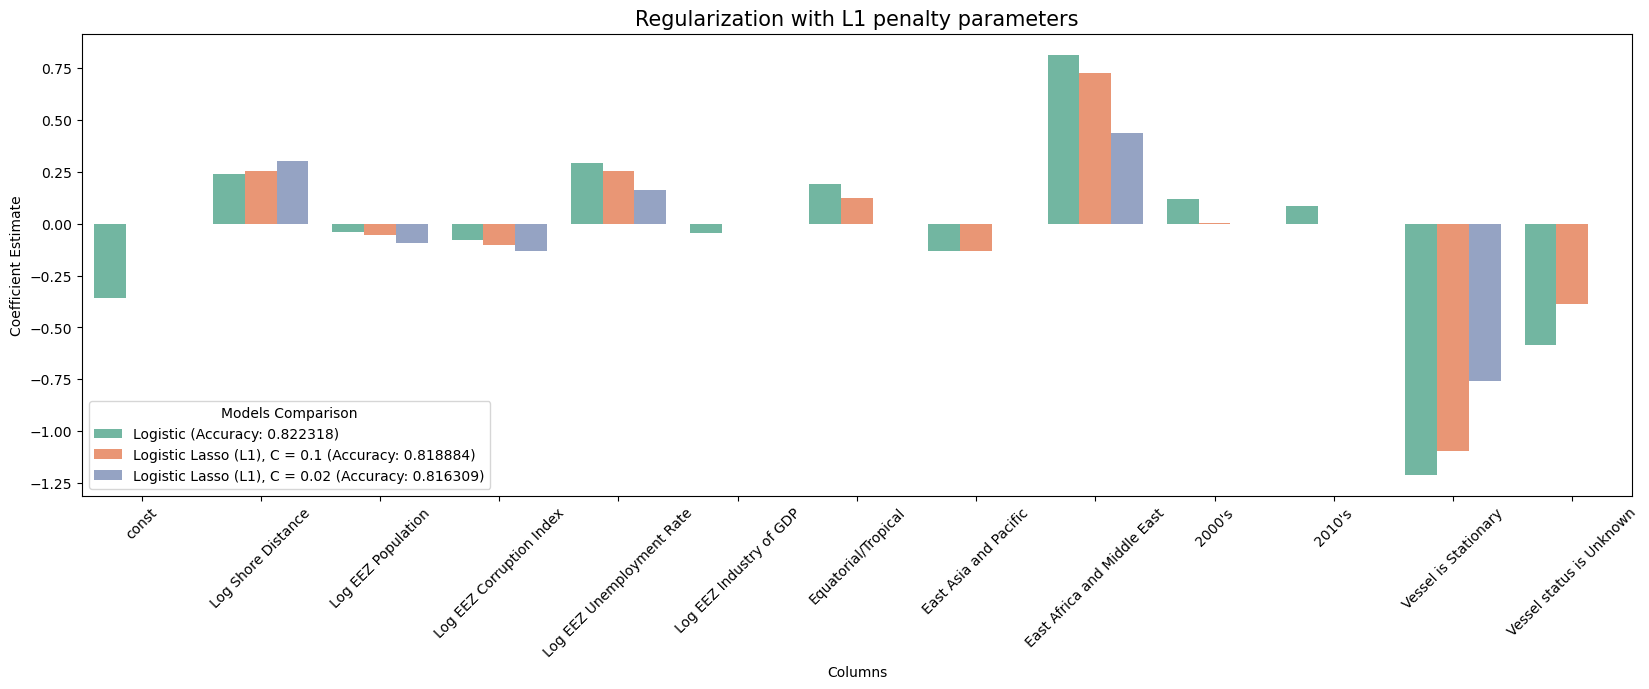

In [238]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
 
logreg_y_pred = logreg.predict(x_test)
 
accuracy = accuracy_score(y_test, logreg_y_pred)
conf_matrix = confusion_matrix(y_test, logreg_y_pred)

logreg_coefficient = pd.DataFrame()
logreg_coefficient["Columns"] = x_train.columns
logreg_coefficient['Coefficient Estimate'] = pd.Series(logreg.coef_.flatten())
logreg_coefficient['Type'] = 'Logistic (Accuracy: '+ str(np.around(accuracy,6))+')'

#============================================ L1 ============================================================
alpha_low = 10 # Greater penalty (C)
logreg_l1 = LogisticRegression(penalty='l1', solver='saga', C=1/alpha_low, max_iter=1000)
logreg_l1.fit(x_train, y_train)

y_pred_l1 = logreg_l1.predict(x_test)
accuracy_l1 = accuracy_score(y_test, y_pred_l1)

logreg_l1_coefficient = pd.DataFrame()
logreg_l1_coefficient["Columns"] = x_train.columns
logreg_l1_coefficient['Coefficient Estimate'] = pd.Series(logreg_l1.coef_.flatten())
logreg_l1_coefficient['Type'] = f'Logistic Lasso (L1), C = {1/alpha_low} (Accuracy: {np.around(accuracy_l1, 6)})'

#============================================ L2 ============================================================

alpha_mid = 50 # middle penalty (C)
logreg_l2 = LogisticRegression(penalty='l1', solver='saga', C=1/alpha_mid, max_iter=1000)
logreg_l2.fit(x_train, y_train)

y_pred_l2 = logreg_l2.predict(x_test)
accuracy_l2 = accuracy_score(y_test, y_pred_l2)

logreg_l2_coefficient = pd.DataFrame()
logreg_l2_coefficient["Columns"] = x_train.columns
logreg_l2_coefficient['Coefficient Estimate'] = pd.Series(logreg_l2.coef_.flatten())
logreg_l2_coefficient['Type'] = f'Logistic Lasso (L1), C = {1/alpha_mid} (Accuracy: {np.around(accuracy_l2, 6)})'

#============================================ L3 ============================================================

# alpha_high = 50 # Smaller penalty (C)
# logreg_l3 = LogisticRegression(penalty='l1', solver='saga', C=1/alpha_high, max_iter=1000)
# logreg_l3.fit(x_train, y_train)

# y_pred_l3 = logreg_l3.predict(x_test)
# accuracy_l3 = accuracy_score(y_test, y_pred_l3)

# logreg_l3_coefficient = pd.DataFrame()
# logreg_l3_coefficient["Columns"] = x_train.columns
# logreg_l3_coefficient['Coefficient Estimate'] = pd.Series(logreg_l3.coef_.flatten())
# logreg_l3_coefficient['Type'] = f'Logistic Lasso (L3), C = {np.around(1/alpha_high,2)} (Accuracy: {np.around(accuracy_l3, 6)})'


#============================================ GRAPH ===========================================================

frames = [logreg_coefficient, logreg_l1_coefficient, logreg_l2_coefficient]#,logreg_l3_coefficient]
all_coefs = pd.concat(frames)

fig, ax = plt.subplots(figsize=(20, 6))

sns.barplot(x=all_coefs["Columns"], y=all_coefs['Coefficient Estimate'], hue=all_coefs['Type'],palette="Set2")

plt.xticks(rotation=45)
plt.title('Regularization with L1 penalty parameters',fontsize=15)
plt.legend(loc='lower left',title='Models Comparison')
plt.show()

#### D6: Fixed model

In [222]:
y_new = mydata['outcome']
fixedlist = ['Log Shore Distance', 'Log EEZ Population', 'Log EEZ Corruption Index',
            'Log EEZ Unemployment Rate','East Africa and Middle East' ,'Vessel is Stationary']

X_new=mydata[fixedlist]
X_new = X_new.replace(np.nan).dropna()

X_new = X_new.astype(int)
X_new=sm.add_constant(X_new)
y_new = y_new[X_new.index]

model_new = sm.Logit(y_new, X_new)
result_new = model_new.fit()

summary_new = result_new.summary2()
summary_df = summary_new.tables[1].copy()
summary.tables[1] = summary_df
print(summary)

Optimization terminated successfully.
         Current function value: 0.478485
         Iterations 6
                               Results: Logit
Model:                  Logit               Method:              MLE        
Dependent Variable:     outcome             Pseudo R-squared:    0.180      
Date:                   2024-08-15 13:44    AIC:                 5432.4598  
No. Observations:       5821                BIC:                 5519.1598  
Df Model:               12                  Log-Likelihood:      -2703.2    
Df Residuals:           5808                LL-Null:             -3297.0    
Converged:              1.0000              LLR p-value:         8.0884e-247
No. Iterations:         6.0000              Scale:               1.0000     
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
const

C:\Users\saarp\AppData\Local\Temp\ipykernel_20520\1732569280.py:6: FutureWarning: DataFrame.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  X_new = X_new.replace(np.nan).dropna()
